In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import DifferentiableHOS as DHOS
import flowpm
import pickle
import flowpm.tfpower as tfpower
import flowpm.scipy.interpolate as interpolate
from flowpm.tfpower import linear_matter_power
import jax
from flowpm import tfpm
import jax_cosmo as jc
from DifferentiableHOS.pk import pk as pkl
import jax_cosmo.power as power

Populating the interactive namespace from numpy and matplotlib


In [2]:
box_size=64.     # Transverse comoving size of the simulation volume
nc = 64          # Number of transverse voxels in the simulation volume
field_size = 5.   # Size of the lensing field in degrees
nsteps=40
B=1

In [3]:
cosmology = flowpm.cosmology.Planck15()

In [4]:
stages = np.linspace(0.1, 1., nsteps, endpoint=True)

# Create some initial conditions
k = tf.constant(np.logspace(-4, 1, 512), dtype=tf.float32)
pk = linear_matter_power(cosmology, k)
pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)
initial_conditions = flowpm.linear_field(
      [nc, nc, nc],
      [box_size, box_size, box_size],
      pk_fun,
      batch_size=1)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)


In [5]:
@tf.function
def nbody(cosmo,state,stages,nc,pm_nc_factor):
    stages=tf.cast(stages, dtype=tf.float32)
    states = tfpm.nbody(cosmo,
                           state,
                    stages, [nc,nc,nc],
                    pm_nc_factor,
                    return_intermediate_states=True)
    return states



In [6]:
 # Run the Nbody
states = flowpm.nbody(cosmology,
                        initial_state,
                    stages, [nc, nc, nc],
                    pm_nc_factor=B,
                    return_intermediate_states=True)

In [7]:
PGD_param=pickle.load(open('/global/u1/d/dlan/flowpm/scripts/results_fit_PGD.pkl', 'rb'))

In [8]:
alpha=PGD_param['alpha']
kl=PGD_param['kl']
ks=PGD_param['ks']
pgdparams=PGD_param['pgdparams']

In [9]:
cosmo=jc.Planck15()

In [11]:
dx=tfpm.PGD_correction(states[-1][1],pgdparams,[nc,nc,nc],pm_nc_factor=B)
new_state= states[-1][1][0]+dx
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), new_state)
final_field=tf.reshape(final_field, [nc, nc, nc])
k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                        box_size]),kmin=0.1,dk=2*np.pi/box_size)
final_field1 = flowpm.cic_paint(tf.zeros_like(initial_conditions), states[-1][1][0])
final_field1=tf.reshape(final_field1, [nc, nc, nc])
k1, power_spectrum1 = pkl(final_field1,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                     box_size]),kmin=0.1,dk=2*np.pi/box_size)
pjax=power.nonlinear_matter_power(cosmo, k, states[-1][0])

/global/homes/d/dlan/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [13]:
pk_array=[]
pk_array1=[]
pk_jax=[]
for i in range(len(states)):
    print(i)
    dx=tfpm.PGD_correction(states[i][1],pgdparams,[nc,nc,nc],pm_nc_factor=B)
    new_state= states[i][1][0]+dx
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), new_state)
    final_field=tf.reshape(final_field, [nc, nc, nc])
    k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                            box_size]),kmin=0.1,dk=2*np.pi/box_size)
    final_field1 = flowpm.cic_paint(tf.zeros_like(initial_conditions), states[i][1][0])
    final_field1=tf.reshape(final_field1, [nc, nc, nc])
    k1, power_spectrum1 = pkl(final_field1,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                         box_size]),kmin=0.1,dk=2*np.pi/box_size)

    pk_array.append(power_spectrum)
    pk_array1.append(power_spectrum1)
    pk_jax.append(power.nonlinear_matter_power(cosmo, k, states[i][0]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [14]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

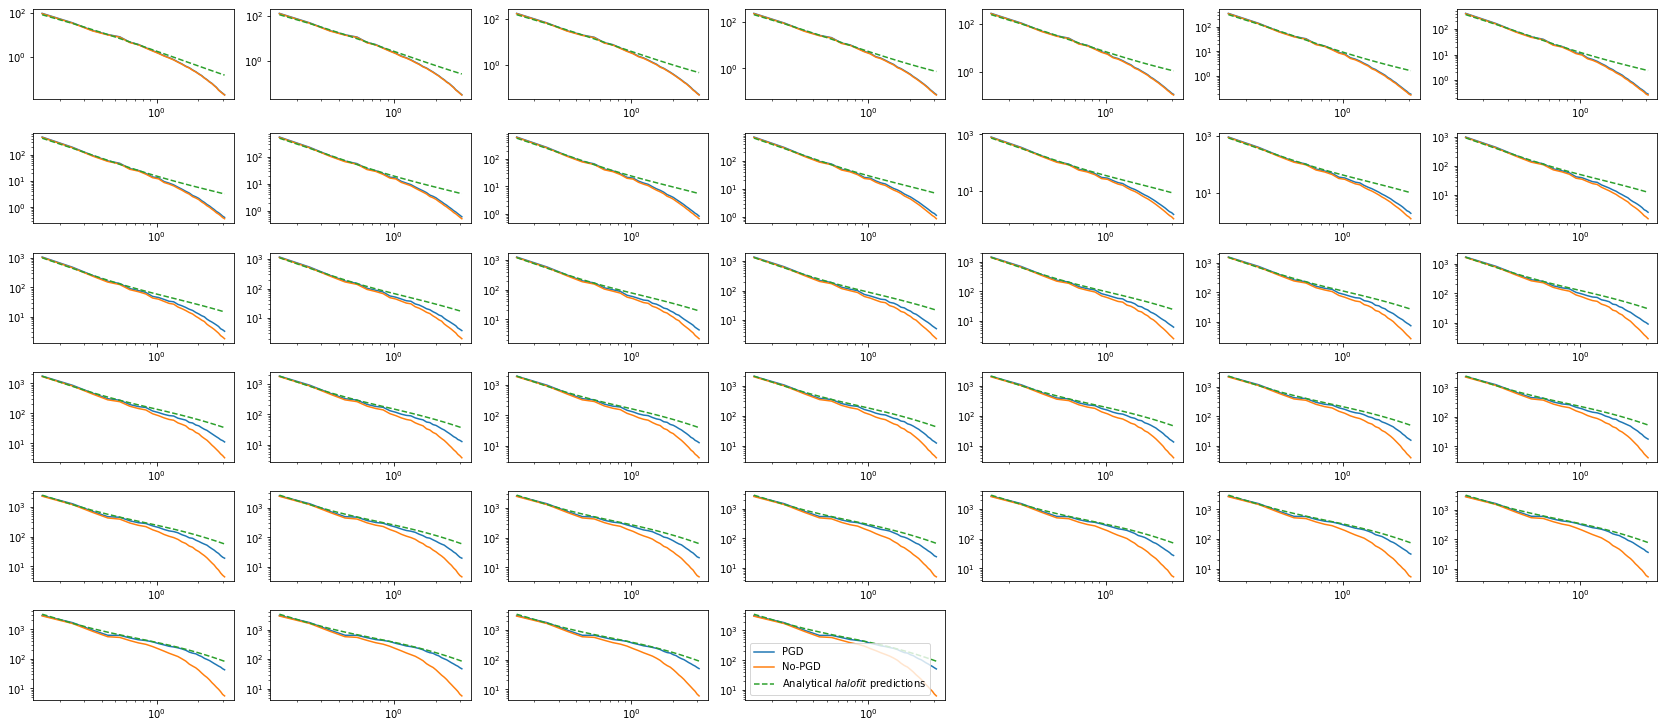

In [15]:
figsize = (23, 10)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 7
rows =6
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(pk_array))
# for ax, p in zip(axs, pk_array2):
#     #ax.set_title('markevery=%s' % str(case))
#     ax.loglog(k, p,label='Dif. Sim. B=2 ')
for ax, pi in zip(axs, pk_array):
    ax.loglog(k, pi,label='PGD')
for ax, px in zip(axs, pk_array1):
    ax.loglog(k, px,label='No-PGD')
for ax, pj in zip(axs, pk_jax):
    ax.loglog(k, pj,'--',label='Analytical $halofit$ predictions')
legend(loc='lower left')
#fig.savefig('png_mixt.png',dpi=250)

# Looking at the  PGD kernel 

<ipython-input-16-389f7c3a58f7>:2: RuntimeWarning: divide by zero encountered in true_divide
  plot(k,  np.exp(-kl**2 / k**2) * np.exp(-k**4 / ks**2))


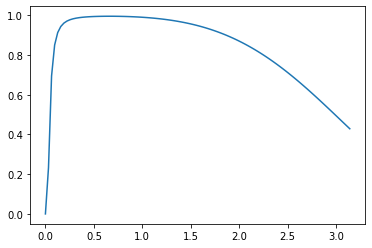

In [16]:
k = linspace(0, 3.14, 100)
plot(k,  np.exp(-kl**2 / k**2) * np.exp(-k**4 / ks**2))
